# Analysis of Shh target genes when the Shh pathway is conditionally activated in astrocytes.
## Line profiles were taken from immuno images of Kir4.1, Glast, GlyT, and GAT3 using the associated imagej scripts

# Important Note:
## The stains in this experiment are mislabeled. 
## label =  real stain
glt   =   Kir4.1  
glast  =  GAT3 (stain failed)  
kir   =   GLT1  
gat   =  Glast   

## Libraries

In [1]:
#from profiles import profiles
# from profiles.profiles import trace_per_animal_by_geno, plot_datapoints, grouped_ttests
import pandas as pd
import re
import os
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Libraries
import os
from pandas import read_csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import stats

pd.options.mode.chained_assignment = None


# profile class
class Profile:
    # TODO: change data slots to numpy arrays, pos, pos_zero, and signal
    # TODO: dataframe should have multi-index with geno and stain
    """A single profile constructed from metadata and position and signal arrays"""
    def __init__(self,
                 name=None,
                 label=None,
                 animal=None,
                 geno=None,
                 image=None,
                 line=None,
                 stain=None,
                 region=None,
                 zero=None,
                 data=None,
                 # signal_raw=None
                 ):
        self.name = name
        self.label = label  # will be the label string from imagej
        self.animal = animal
        self.geno = geno
        self.image = image  # image that the profile was acquired from
        self.line = line
        self.stain = stain  # protein that was imaged
        self.region = region
        self.zero = zero  # position
        self.data = data
        # self.data = pd.DataFrame(columns=['pos_raw', 'pos',  'signal', 'signal_norm'])


# dataset class

class ProfileDataset:
    """A collection of profiles and methods to output data in useful formats"""
    # TODO: make method to output dataframe without positions containing NaNs
    # TODO: make data have a multi index -- NEED TO TEST
    # TODO: use numpy arrays where possible
    # TODO: concat all profile data as tuples/lists only append df after collection of all
    # TODO: add a slot for cutoff positions (where to crop data)
    # TODO: add cutoff flag for plot functions
    def __init__(self, name=None):
        self.name = name
        self.profiles = []  # list of profiles
        self.subregions = {}
        self.meta = []
        self.data = []
        self.summary = []
        self.cutoff = []
        self.scale = None  # micrometers per pixel

    def append(self, profile):
        """method to a append profile to the set"""
        self.profiles.append(profile)

    def long(self):
        """method to compile all profiles and metadata into a single dataframe.
        format suitable for plotting in seaborn"""
        df = pd.DataFrame(columns=['pos_raw',
                                   'pos',
                                   'signal',
                                   'geno',
                                   'image',
                                   'name',
                                   'stain',
                                   'region'])
        for profile in self.profiles:
            profile_df = profile.data
            profile_df['name'] = profile.name
            profile_df['label'] = profile.label
            profile_df['animal'] = profile.animal
            profile_df['geno'] = profile.geno
            profile_df['region'] = profile.region
            profile_df['image'] = profile.image
            profile_df['stain'] = profile.stain
            df = df.append(profile_df, ignore_index=True)
            # df = df.set_index(['stain', 'geno'])
            # TODO: sort the indexes to improve performance
        # print(df)
        return df

    def create_meta(self):
        meta_list = []
        for profile in self.profiles:
            meta_list.append([profile.name, profile.image, profile.animal, profile.geno, profile.stain, profile.region])
        meta = pd.DataFrame(meta_list, columns=['name', 'image', 'animal', 'geno', 'stain', 'region'])
        self.meta = meta

    def wide(self):
        """method to output profile data in wide format suitable for heatmap"""
        pass

    # make a method to call individual profiles
    # method to output whole dataset as wide or long
    # method to filter data
    # method to output dataset characteristics number of animals, images, etc...


def get_file_info(r, file):
    data_file = os.path.join(r, file)
    data = read_csv(data_file)
    image_file = file.split("_profiles.csv")[0]
    meta_file = r + image_file[3:].split(".oif")[0] + "_meta.csv"
    meta = read_csv(meta_file)
    return data, meta, image_file





# iterate parse_ij function over all files in folder

def parse_data_folder(path, animal_meta):
    # TODO: make this function more efficient. concat tuples not dfs
    """This function will concatenate all of the data from a single folder into a single dataset object"""
    dataset = ProfileDataset()
    for r, d, f in os.walk(path):
        for file in f:
            if '_profiles.csv' in file:
                data, meta, image_file = get_file_info(r, file)
                image_profiles = parse_ij(data, meta, animal_meta, image_file)
                for profile in image_profiles.profiles:
                    dataset.append(profile)
    # TODO: add output messages stating the number of images and profiles
    return dataset


# plot_heatmap of each profile
def plot_heatmap(data, stain, crop=False):
    # TODO: test crop flag
    """generate a heatmap of the dataset sorted by genotype"""
    if not crop:
        stain_data = data[data['stain'] == stain].sort_values(by=['geno'])
        pivot = stain_data.pivot_table(index='label', columns='pos', values='signal')
    if crop:
        # TODO: test if cutoff values have been added to dataset. return message if not
        cropped_data = data[(pos > data.cutoff[0]) & (pos < data.cutoff[1])]
        stain_data = cropped_data[cropped_data['stain'] == stain].sort_values(by=['geno'])
        pivot = stain_data.pivot_table(index='label', columns='pos', values='signal')
    hm = sns.heatmap(pivot, yticklabels='')
    hm.set_title(stain + " profiles")
    return hm

# function to plot per animal - no ci


def trace_per_animal(data, stain):
    # TODO: make this function annotate regions of the dataset
    spy_start = -50
    spy_end = 50
    trace = sns.lineplot(data=data[(data['stain'] == stain)],
                         x='pos',
                         y='signal',
                         hue='animal',
                         palette=sns.color_palette("colorblind", data[(data['stain'] == stain)]['animal'].nunique()),
                         estimator='mean',
                         ci=None,
                         alpha=0.5)
    trace.set_title("average " + stain + " profile per animal - no ci")

    trace.axvspan((spy_start - 100), spy_start, color=sns.xkcd_rgb['grey'], alpha=0.25, )
    trace.axvspan(spy_end, (spy_end + 100), color=sns.xkcd_rgb['grey'], alpha=0.25)
    trace.set_alpha(0.2)

    return trace


# plot means with sd confidence interval
# need to fix # of n's ---  collapse per animal
def trace_per_geno(data, stain):
    spy_start = -50
    spy_end = 50

    trace = sns.lineplot(data=data[(data['stain'] == stain)],
                         x='pos',
                         y='signal',
                         palette=sns.color_palette("colorblind", data[(data['stain'] == stain)]['geno'].nunique()),
                         hue='geno',
                         ci=68)
    trace.set_title("average " + stain + " profile per genotype - ci")
    trace.axvspan((spy_start - 100), spy_start, color=sns.xkcd_rgb['grey'], alpha=0.25)
    trace.axvspan(spy_end, (spy_end + 100), color=sns.xkcd_rgb['grey'], alpha=0.25)
    return trace


def trace_per_animal_by_geno(data):
    """Creates a sns facet grid of profiles collapsed at the animal and gen levels.
       The input is ProfileDataSet.data"""
    # fig = plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
    spy_start = -50
    spy_end = 50

    sub_agg = data. \
        groupby(['stain', 'region', 'geno', 'animal', 'pos']). \
        agg(mean_signal=pd.NamedAgg(column='signal', aggfunc='mean'))
    sub_agg.reset_index(inplace=True)
    sub_agg = sub_agg.astype({'pos': 'int64'})
    fig = sns.relplot(x="pos",
                      y="mean_signal",
                      palette=sns.color_palette("colorblind", data['geno'].nunique()),
                      hue="geno",
                      col="region",
                      row="stain",
                      height=3, aspect=1.5, linewidth=1,
                      kind="line",
                      data=sub_agg[(sub_agg["pos"] >= -500) & (sub_agg["pos"] <= 1000)],
                      ci=68,
                      facet_kws={'sharey': False, 'sharex': True}
                      )

    fig.map(plt.axvspan, xmin=(spy_start - 100), xmax=spy_start, color=sns.xkcd_rgb['grey'], alpha=0.25)
    fig.map(plt.axvspan, xmin=spy_end, xmax=(spy_end + 100), color=sns.xkcd_rgb['grey'], alpha=0.25)
    return fig


# region analysis function
# This function needs to be made to accept any dataset
"""
def region_analysis(data, region, geno_loc):
    # mean signal across region
    for region in regions
    
        for geno in genos
    region_wt = data[data['geno'] == 'Shh+/+'].iloc[:, regions[region]].mean(axis=1)
    region_cc = data[data['geno'] == 'Shhc/c'].iloc[:, regions[region]].mean(axis=1)
    print("t-test of mean across " + region)
    plot dot plots for each geno in each region
    output summary table
    stat = stats.ttest_rel(region_wt, region_cc, axis=0)
    print(stat)

    # return bar graph with p value and print stats for repeated and mean for the region
    bar = sns.barplot(y=data.iloc[:, regions[region]].mean(axis=1),
                      x=data.iloc[:, geno_loc],
                      ci='sd')
    bar.set_title("mean fluorescence of " + region)
    bar.text(0.5, 0.95,
             "p=" + str(round(stat.pvalue, 3)),
             horizontalalignment='center',
             verticalalignment='center',
             transform=bar.transAxes)
    # repeated measures
    # region_tom_rm = data[data['geno'] == 'Tom'].iloc[:, regions[region]]
    # region_M2_rm = data[data['geno'] == 'SmoM2'].iloc[:, regions[region]]
    # print("t-test of across " + region)
    # print(stats.ttest_rel(region_tom_rm, region_M2_rm, axis=0))
    return bar
"""

# scale data so that x axis is consistent

# Function to compare regions


def trace_per_region(data, stain):
    spy_start = -50
    spy_end = 50
    trace = sns.lineplot(data=data[(data['stain'] == stain)],
                         x='pos',
                         y='signal',
                         palette=sns.color_palette("colorblind", data[(data['stain'] == stain)]['geno'].nunique()),
                         hue='geno',
                         style='region')
    trace.set_title("average " + stain + " profile per genotype")
    trace.axvspan((spy_start - 100), spy_start, color=sns.xkcd_rgb['grey'], alpha=0.25)
    trace.axvspan(spy_end, (spy_end + 100), color=sns.xkcd_rgb['grey'], alpha=0.25)
    return trace


def plot_datapoints(data, subregions, style, save_prefix):
    """Generates a series of plots showing the mean signal for each animal and each subregion.
        data: ProfileDataset.data. A long pandas dataframe.
        subregions: a dict of subregions. names as key. numpy range as values
    """
    for subregion in subregions:
        sub_agg = data[data['pos'].
                        isin(subregions[subregion])].\
                        groupby(['stain', 'region', 'geno', 'animal']).\
                        agg(mean_signal=pd.NamedAgg(column='signal', aggfunc='mean'))
        sns.set_style("whitegrid")
        ax = sns.catplot(data=sub_agg.reset_index(),
                         kind=style,
                         dodge=True,
                         y='mean_signal',
                         x='stain',
                         hue='geno',
                         col='region',
                         ci=68)
        ax.fig.suptitle(subregion, fontsize=24, x=0.2)
        ax.fig.savefig(save_prefix + subregion + ".pdf")
        plt.show()


def grouped_ttests(data, subregions):
    """
    """
    # TODO: Add test for the number of groups. give error if more than 2 groups
    d = []
    for subregion in subregions:
        sub_agg = data[data['pos'].
                       isin(subregions[subregion])]. \
            groupby(['stain', 'region', 'geno', 'animal']). \
            agg(mean_signal=pd.NamedAgg(column='signal', aggfunc='mean'))

        for stain in sub_agg.index.get_level_values(0).unique():

            for region in sub_agg.index.get_level_values(1).unique():
                genos = [geno for geno in sub_agg.index.get_level_values(2).unique()]
                values1 = sub_agg.xs((stain, region, genos[0]), level=('stain', 'region', 'geno')).values
                values2 = sub_agg.xs((stain, region, genos[1]), level=('stain', 'region', 'geno')).values
                t, p = stats.ttest_ind(values1, values2)

                d.append(
                    {
                        "stain": stain,
                        "region": region,
                        "subregion": subregion,
                        "geno1": genos[0],
                        "geno2": genos[1],
                        "geno1_mean": values1.mean(),
                        "geno1_sem": stats.sem(values1)[0],
                        "geno2_mean": values2.mean(),
                        "geno2_sem": stats.sem(values2)[0],
                        "geno1_n": len(values1),
                        "geno2_n": len(values2),
                        "p-value": p[0]
                    }
                )

    return pd.DataFrame(d)


## File Locations and image scale


In [3]:
data_path = "../data/CA1_M2_20210803/"

animal_file = data_path + "animal_meta.csv"
animal_meta = pd.read_csv(animal_file)
animal_meta['animal'] = animal_meta['animal'].astype(str)

# add image scale
# add regions
zero = 0
subregions = {'SPy': np.r_[zero - 50:zero + 50],
           'periSPy': np.r_[zero - 150:zero - 50, zero + 50:zero + 150],
              'SO': np.r_[-400:-150],
              'SR': np.r_[100:500]
           }

## The cohort:

In [4]:
print(animal_meta.loc[:, ('animal', 'geno', 'sex')])

  animal                            geno   sex
0  18878    Aldh1l1+/Cre ; Rosa26Tom/Tom  male
1  18879  Aldh1l1+/Cre ; Rosa26Tom/SmoM2  male
2  18880    Aldh1l1+/Cre ; Rosa26Tom/Tom  male
3  18881  Aldh1l1+/Cre ; Rosa26Tom/SmoM2  male
4  18893  Aldh1l1+/Cre ; Rosa26Tom/SmoM2  male
5  18894    Aldh1l1+/Cre ; Rosa26Tom/Tom  male
6  18895  Aldh1l1+/Cre ; Rosa26Tom/SmoM2  male
7  18896    Aldh1l1+/Cre ; Rosa26Tom/Tom  male


## rename files missing underscore after last stain

In [5]:
# several of the files do not have an underscore between the last stain and the index number.
# find all of those files and add an underscore in the right place.

def fix_file_names(folder):
    """Finds the files that are missing the underscore and adds it
    """
    bad_file = re.compile('(\S*\S{4,6}_\S{2,5}_\S{2,5}_kir)(\d{4}\S*)')
 
    for (dp, dn, fn) in os.walk(folder):
        for f in fn:
            #print(f)
            if bad_file.match(f):
                old_file = os.path.join(dp,f)
                new_file = os.path.join(dp, bad_file.search(f)[1] + "_" + bad_file.search(f)[2])
                print(old_file)
                print(new_file)
                #os.rename(old_file, new_file)
                #print(" ")
fix_file_names(data_path)

In [6]:
# All of the file names need to be changed in the meta files

# Add region to file name
A region needs to added to each file name and in all of the meta files.

## run data parsing over whole folder to generate the dataset object

In [25]:

def parse_ij(input, metadata, animal_meta, image_file):
    """parse imagej generated spreadsheets into a list of profile objects"""
    dataset = ProfileDataset()

    def get_image_info(image_file):
        """extract image metadata"""

        regex = re.compile("(C\d)-((\S{4,6})_(\S{2,5})_(\S{2,5})_(\S{2,5})_\S{4}.oif)")
        regex_match = re.search(regex, image_file)
        return regex_match

    for label in metadata['Label']:
        data = pd.DataFrame(columns=['pos_raw',  'signal'], index=input.index)
        row_index = metadata.loc[metadata['Label'] == label].index.tolist()[0]
        if row_index > 10:
            break
        print(label)
        print(row_index)
        zero = round(metadata.iloc[row_index]['Length'], 0)
        print(zero)
        match = get_image_info(image_file)
        animal = match[3]
        # print('animal = ', match[3])
        image = match[2]
        # print('image = ', match[0])
        geno = animal_meta[animal_meta['animal'] == animal]['geno'].values[0]
        if match[1] == "C1":
            stain = match[4]
        elif match[1] == "C2":
            stain = match[5]
        elif match[1] == "C3":
            stain = match[6]
        # region = match[7]
        # print(type(input.iloc[:, row_index:row_index + 2]))
        # data.index = input.index
        data['pos_raw'] = input.iloc[:, row_index * 2]
        data['signal'] = input.iloc[:, row_index * 2 + 1]
        data['pos'] = data['pos_raw'] - zero
        dataset.append(Profile(label=label,
                               animal=animal,
                               geno=geno,
                               image=image,
                               line=None,
                               stain=stain,
                               region='CA1',
                               zero=zero,
                               data=data))
    return dataset

In [26]:
M2 = parse_data_folder(data_path, animal_meta)
# populate metadata slot on dataset object
M2.create_meta()
M2.meta.head()

C3-18878_gat_tom_glt_0001.oif:0427-0085
0
445.0
C3-18878_gat_tom_glt_0001.oif:0451-0257
1
438.0
C3-18878_gat_tom_glt_0001.oif:0431-0418
2
508.0
C3-18878_gat_tom_glt_0001.oif:0437-0533
3
507.0
C3-18878_gat_tom_glt_0001.oif:0429-0686
4
508.0
C3-18878_gat_tom_glt_0001.oif:0446-0811
5
469.0
C3-18878_gat_tom_glt_0001.oif:0446-0963
6
456.0
C3-18878_gat_tom_glt_0001.oif:0450-1138
7
482.0
C3-18878_gat_tom_glt_0001.oif:0482-1317
8
519.0
C3-18878_gat_tom_glt_0001.oif:0535-1486
9
493.0
C3-18878_gat_tom_glt_0002.oif:0475-0099
0
488.0
C3-18878_gat_tom_glt_0002.oif:0471-0257
1
498.0
C3-18878_gat_tom_glt_0002.oif:0431-0467
2
487.0
C3-18878_gat_tom_glt_0002.oif:0389-0655
3
470.0
C3-18878_gat_tom_glt_0002.oif:0384-0794
4
441.0
C3-18878_gat_tom_glt_0002.oif:0390-0987
5
475.0
C3-18878_gat_tom_glt_0002.oif:0415-1204
6
450.0
C3-18878_gat_tom_glt_0002.oif:0401-1328
7
478.0
C3-18878_gat_tom_glt_0013.oif:0348-0074
0
412.0
C3-18878_gat_tom_glt_0013.oif:0328-0237
1
403.0
C3-18878_gat_tom_glt_0013.oif:0308-0361


C3-18879_glast_tom_kir0033.oif:0235-0628
4
369.0
C3-18879_glast_tom_kir0033.oif:0234-0817
5
370.0
C3-18879_glast_tom_kir0033.oif:0247-1005
6
375.0
C3-18879_glast_tom_kir0033.oif:0264-1159
7
395.0
C3-18879_glast_tom_kir0033.oif:0324-1351
8
387.0
C3-18879_glast_tom_kir0033.oif:0374-1521
9
409.0
C3-18879_glast_tom_kir0034.oif:0499-0095
0
448.0
C3-18879_glast_tom_kir0034.oif:0444-0332
1
459.0
C3-18879_glast_tom_kir0034.oif:0413-0509
2
424.0
C3-18879_glast_tom_kir0034.oif:0375-0632
3
413.0
C3-18879_glast_tom_kir0034.oif:0377-0792
4
408.0
C3-18879_glast_tom_kir0034.oif:0371-0921
5
402.0
C3-18879_glast_tom_kir0034.oif:0373-1079
6
402.0
C3-18879_glast_tom_kir0034.oif:0381-1233
7
390.0
C3-18879_glast_tom_kir0034.oif:0426-1486
8
400.0
C3-18879_glast_tom_kir0049.oif:0306-0079
0
411.0
C3-18879_glast_tom_kir0049.oif:0282-0287
1
393.0
C3-18879_glast_tom_kir0049.oif:0269-0433
2
397.0
C3-18879_glast_tom_kir0049.oif:0242-0592
3
387.0
C3-18879_glast_tom_kir0049.oif:0251-0750
4
382.0
C3-18879_glast_tom_k

C3-18881_glast_tom_kir0006.oif:0458-0193
1
432.0
C3-18881_glast_tom_kir0006.oif:0436-0285
2
450.0
C3-18881_glast_tom_kir0006.oif:0414-0440
3
419.0
C3-18881_glast_tom_kir0006.oif:0405-0598
4
424.0
C3-18881_glast_tom_kir0006.oif:0401-0772
5
462.0
C3-18881_glast_tom_kir0006.oif:0391-0893
6
472.0
C3-18881_glast_tom_kir0006.oif:0407-1039
7
479.0
C3-18881_glast_tom_kir0006.oif:0430-1218
8
463.0
C3-18881_glast_tom_kir0006.oif:0455-1352
9
478.0
C3-18881_glast_tom_kir0006.oif:0528-1501
10
420.0
C3-18881_glast_tom_kir0007.oif:0445-0095
0
447.0
C3-18881_glast_tom_kir0007.oif:0412-0253
1
461.0
C3-18881_glast_tom_kir0007.oif:0401-0376
2
443.0
C3-18881_glast_tom_kir0007.oif:0377-0504
3
465.0
C3-18881_glast_tom_kir0007.oif:0385-0761
4
426.0
C3-18881_glast_tom_kir0007.oif:0397-0844
5
401.0
C3-18881_glast_tom_kir0007.oif:0393-0923
6
437.0
C3-18881_glast_tom_kir0007.oif:0390-1052
7
435.0
C3-18881_glast_tom_kir0007.oif:0403-1130
8
406.0
C3-18881_glast_tom_kir0007.oif:0411-1248
9
393.0
C3-18881_glast_tom_

C3-18894_gat_tom_glt_0012.oif:0380-0215
1
450.0
C3-18894_gat_tom_glt_0012.oif:0381-0340
2
459.0
C3-18894_gat_tom_glt_0012.oif:0382-0520
3
455.0
C3-18894_gat_tom_glt_0012.oif:0388-0639
4
449.0
C3-18894_gat_tom_glt_0012.oif:0379-0779
5
486.0
C3-18894_gat_tom_glt_0012.oif:0377-0895
6
478.0
C3-18894_gat_tom_glt_0012.oif:0379-1027
7
459.0
C3-18894_gat_tom_glt_0012.oif:0389-1109
8
458.0
C3-18894_gat_tom_glt_0012.oif:0410-1281
9
443.0
C3-18894_gat_tom_glt_0012.oif:0445-1450
10
457.0
C3-18894_gat_tom_glt_0024.oif:0382-0066
0
475.0
C3-18894_gat_tom_glt_0024.oif:0368-0259
1
474.0
C3-18894_gat_tom_glt_0024.oif:0361-0421
2
433.0
C3-18894_gat_tom_glt_0024.oif:0352-0638
3
456.0
C3-18894_gat_tom_glt_0024.oif:0337-0853
4
498.0
C3-18894_gat_tom_glt_0024.oif:0361-1090
5
506.0
C3-18894_gat_tom_glt_0024.oif:0384-1266
6
526.0
C3-18894_gat_tom_glt_0024.oif:0424-1433
7
531.0
C3-18894_gat_tom_glt_0024.oif:0476-1505
8
501.0
C3-18894_gat_tom_glt_0046.oif:0382-0064
0
420.0
C3-18894_gat_tom_glt_0046.oif:0351-0187

C3-18895_glast_tom_kir0063.oif:0428-0629
3
441.0
C3-18895_glast_tom_kir0063.oif:0424-0776
4
451.0
C3-18895_glast_tom_kir0063.oif:0405-1047
5
451.0
C3-18895_glast_tom_kir0063.oif:0410-1289
6
442.0
C3-18895_glast_tom_kir0063.oif:0406-1450
7
468.0
C3-18896_gat_tom_glt_0015.oif:0395-0079
0
447.0
C3-18896_gat_tom_glt_0015.oif:0375-0219
1
440.0
C3-18896_gat_tom_glt_0015.oif:0360-0388
2
449.0
C3-18896_gat_tom_glt_0015.oif:0341-0561
3
444.0
C3-18896_gat_tom_glt_0015.oif:0328-0726
4
466.0
C3-18896_gat_tom_glt_0015.oif:0350-0972
5
439.0
C3-18896_gat_tom_glt_0015.oif:0364-1179
6
447.0
C3-18896_gat_tom_glt_0015.oif:0398-1386
7
441.0
C3-18896_gat_tom_glt_0015.oif:0459-1545
8
389.0
C3-18896_gat_tom_glt_0016.oif:0507-0072
0
362.0
C3-18896_gat_tom_glt_0016.oif:0431-0222
1
417.0
C3-18896_gat_tom_glt_0016.oif:0371-0429
2
425.0
C3-18896_gat_tom_glt_0016.oif:0337-0637
3
423.0
C3-18896_gat_tom_glt_0016.oif:0316-0801
4
438.0
C3-18896_gat_tom_glt_0016.oif:0291-0953
5
456.0
C3-18896_gat_tom_glt_0016.oif:0306-

C3-18878_glast_tom_kir0002.oif:0276-0615
3
447.0
C3-18878_glast_tom_kir0002.oif:0282-0768
4
437.0
C3-18878_glast_tom_kir0002.oif:0274-0905
5
449.0
C3-18878_glast_tom_kir0002.oif:0309-1147
6
454.0
C3-18878_glast_tom_kir0002.oif:0356-1288
7
435.0
C3-18878_glast_tom_kir0002.oif:0393-1447
8
439.0
C3-18878_glast_tom_kir0031.oif:0349-0061
0
396.0
C3-18878_glast_tom_kir0031.oif:0312-0239
1
413.0
C3-18878_glast_tom_kir0031.oif:0299-0393
2
389.0
C3-18878_glast_tom_kir0031.oif:0306-0531
3
395.0
C3-18878_glast_tom_kir0031.oif:0316-0849
4
410.0
C3-18878_glast_tom_kir0031.oif:0301-0664
5
413.0
C3-18878_glast_tom_kir0031.oif:0343-1023
6
418.0
C3-18878_glast_tom_kir0031.oif:0357-1215
7
409.0
C3-18878_glast_tom_kir0031.oif:0407-1381
8
432.0
C3-18878_glast_tom_kir0031.oif:0425-1544
9
401.0
C3-18878_glast_tom_kir0032.oif:0393-0097
0
411.0
C3-18878_glast_tom_kir0032.oif:0370-0257
1
399.0
C3-18878_glast_tom_kir0032.oif:0363-0441
2
396.0
C3-18878_glast_tom_kir0032.oif:0352-0576
3
407.0
C3-18878_glast_tom_k

C3-18880_gat_tom_glt_0041.oif:0518-1440
8
528.0
C3-18880_gat_tom_glt_0042.oif:0484-0099
0
554.0
C3-18880_gat_tom_glt_0042.oif:0455-0329
1
527.0
C3-18880_gat_tom_glt_0042.oif:0416-0581
2
519.0
C3-18880_gat_tom_glt_0042.oif:0449-0861
3
509.0
C3-18880_gat_tom_glt_0042.oif:0469-1083
4
485.0
C3-18880_gat_tom_glt_0042.oif:0491-1267
5
502.0
C3-18880_gat_tom_glt_0042.oif:0543-1508
6
505.0
C3-18880_glast_tom_kir0004.oif:0388-0096
0
394.0
C3-18880_glast_tom_kir0004.oif:0359-0295
1
396.0
C3-18880_glast_tom_kir0004.oif:0335-0608
2
434.0
C3-18880_glast_tom_kir0004.oif:0349-0896
3
395.0
C3-18880_glast_tom_kir0004.oif:0397-1149
4
434.0
C3-18880_glast_tom_kir0004.oif:0440-1370
5
472.0
C3-18880_glast_tom_kir0004.oif:0513-1539
6
422.0
C3-18880_glast_tom_kir0005.oif:0507-0071
0
415.0
C3-18880_glast_tom_kir0005.oif:0448-0277
1
425.0
C3-18880_glast_tom_kir0005.oif:0388-0435
2
435.0
C3-18880_glast_tom_kir0005.oif:0324-0660
3
440.0
C3-18880_glast_tom_kir0005.oif:0298-0926
4
407.0
C3-18880_glast_tom_kir0005.o

C3-18893_gat_tom_glt_0010.oif:0317-0732
4
403.0
C3-18893_gat_tom_glt_0010.oif:0331-0933
5
416.0
C3-18893_gat_tom_glt_0010.oif:0334-1048
6
425.0
C3-18893_gat_tom_glt_0010.oif:0347-1205
7
407.0
C3-18893_gat_tom_glt_0010.oif:0388-1425
8
397.0
C3-18893_gat_tom_glt_0010.oif:0419-1541
9
398.0
C3-18893_gat_tom_glt_0021.oif:0411-0085
0
370.0
C3-18893_gat_tom_glt_0021.oif:0379-0217
1
371.0
C3-18893_gat_tom_glt_0021.oif:0361-0333
2
383.0
C3-18893_gat_tom_glt_0021.oif:0338-0435
3
385.0
C3-18893_gat_tom_glt_0021.oif:0306-0576
4
407.0
C3-18893_gat_tom_glt_0021.oif:0289-0716
5
394.0
C3-18893_gat_tom_glt_0021.oif:0292-0902
6
410.0
C3-18893_gat_tom_glt_0021.oif:0302-1090
7
425.0
C3-18893_gat_tom_glt_0021.oif:0317-1269
8
424.0
C3-18893_gat_tom_glt_0021.oif:0387-1466
9
392.0
C3-18893_gat_tom_glt_0021.oif:0417-1543
10
395.0
C3-18893_gat_tom_glt_0022.oif:0460-0063
0
470.0
C3-18893_gat_tom_glt_0022.oif:0422-0201
1
444.0
C3-18893_gat_tom_glt_0022.oif:0387-0350
2
448.0
C3-18893_gat_tom_glt_0022.oif:0362-0500

C3-18894_glast_tom_kir0060.oif:0384-0175
1
429.0
C3-18894_glast_tom_kir0060.oif:0350-0310
2
437.0
C3-18894_glast_tom_kir0060.oif:0341-0443
3
412.0
C3-18894_glast_tom_kir0060.oif:0309-0574
4
438.0
C3-18894_glast_tom_kir0060.oif:0304-0743
5
399.0
C3-18894_glast_tom_kir0060.oif:0298-0938
6
458.0
C3-18894_glast_tom_kir0060.oif:0312-1063
7
474.0
C3-18894_glast_tom_kir0060.oif:0348-1213
8
406.0
C3-18894_glast_tom_kir0060.oif:0370-1419
9
448.0
C3-18894_glast_tom_kir0060.oif:0402-1525
10
450.0
C3-18895_gat_tom_glt_0013.oif:0333-0097
0
386.0
C3-18895_gat_tom_glt_0013.oif:0336-0273
1
371.0
C3-18895_gat_tom_glt_0013.oif:0318-0505
2
412.0
C3-18895_gat_tom_glt_0013.oif:0321-0717
3
415.0
C3-18895_gat_tom_glt_0013.oif:0331-0915
4
435.0
C3-18895_gat_tom_glt_0013.oif:0342-1111
5
440.0
C3-18895_gat_tom_glt_0013.oif:0396-1329
6
408.0
C3-18895_gat_tom_glt_0013.oif:0450-1517
7
410.0
C3-18895_gat_tom_glt_0014.oif:0381-0095
0
412.0
C3-18895_gat_tom_glt_0014.oif:0367-0261
1
425.0
C3-18895_gat_tom_glt_0014.oif

C3-18896_glast_tom_kir0044.oif:0317-1019
5
449.0
C3-18896_glast_tom_kir0044.oif:0340-1256
6
439.0
C3-18896_glast_tom_kir0044.oif:0367-1435
7
445.0
C3-18896_glast_tom_kir0045.oif:0471-0069
0
417.0
C3-18896_glast_tom_kir0045.oif:0445-0191
1
411.0
C3-18896_glast_tom_kir0045.oif:0399-0382
2
427.0
C3-18896_glast_tom_kir0045.oif:0370-0703
3
382.0
C3-18896_glast_tom_kir0045.oif:0382-0958
4
418.0
C3-18896_glast_tom_kir0045.oif:0396-1109
5
416.0
C3-18896_glast_tom_kir0045.oif:0428-1360
6
453.0
C3-18896_glast_tom_kir0045.oif:0460-1513
7
440.0
C3-18896_glast_tom_kir0064.oif:0442-0079
0
395.0
C3-18896_glast_tom_kir0064.oif:0402-0231
1
380.0
C3-18896_glast_tom_kir0064.oif:0355-0393
2
381.0
C3-18896_glast_tom_kir0064.oif:0322-0584
3
370.0
C3-18896_glast_tom_kir0064.oif:0309-0784
4
345.0
C3-18896_glast_tom_kir0064.oif:0297-1014
5
362.0
C3-18896_glast_tom_kir0064.oif:0327-1278
6
395.0
C3-18896_glast_tom_kir0064.oif:0370-1468
7
417.0
C3-18896_glast_tom_kir0065.oif:0420-0055
0
468.0
C3-18896_glast_tom_k

C3-18879_gat_tom_glt_0040.oif:0330-0614
2
387.0
C3-18879_gat_tom_glt_0040.oif:0329-0829
3
398.0
C3-18879_gat_tom_glt_0040.oif:0338-1011
4
390.0
C3-18879_gat_tom_glt_0040.oif:0367-1207
5
409.0
C3-18879_gat_tom_glt_0040.oif:0392-1375
6
383.0
C3-18879_gat_tom_glt_0040.oif:0439-1542
7
360.0
C3-18879_glast_tom_kir0003.oif:0479-0073
0
411.0
C3-18879_glast_tom_kir0003.oif:0462-0174
1
415.0
C3-18879_glast_tom_kir0003.oif:0434-0361
2
428.0
C3-18879_glast_tom_kir0003.oif:0429-0509
3
440.0
C3-18879_glast_tom_kir0003.oif:0409-0659
4
461.0
C3-18879_glast_tom_kir0003.oif:0478-0929
5
415.0
C3-18879_glast_tom_kir0003.oif:0488-1084
6
459.0
C3-18879_glast_tom_kir0003.oif:0529-1222
7
463.0
C3-18879_glast_tom_kir0003.oif:0569-1362
8
464.0
C3-18879_glast_tom_kir0003.oif:0641-1520
9
452.0
C3-18879_glast_tom_kir0033.oif:0308-0062
0
361.0
C3-18879_glast_tom_kir0033.oif:0278-0204
1
375.0
C3-18879_glast_tom_kir0033.oif:0253-0323
2
387.0
C3-18879_glast_tom_kir0033.oif:0244-0418
3
408.0
C3-18879_glast_tom_kir0033

C3-18881_gat_tom_glt_0043.oif:0383-0669
4
476.0
C3-18881_gat_tom_glt_0043.oif:0378-0831
5
471.0
C3-18881_gat_tom_glt_0043.oif:0379-1017
6
465.0
C3-18881_gat_tom_glt_0043.oif:0417-1239
7
402.0
C3-18881_gat_tom_glt_0043.oif:0429-1404
8
410.0
C3-18881_gat_tom_glt_0044.oif:0466-0064
0
417.0
C3-18881_gat_tom_glt_0044.oif:0430-0219
1
451.0
C3-18881_gat_tom_glt_0044.oif:0405-0419
2
468.0
C3-18881_gat_tom_glt_0044.oif:0399-0561
3
482.0
C3-18881_gat_tom_glt_0044.oif:0409-0731
4
460.0
C3-18881_gat_tom_glt_0044.oif:0435-0940
5
470.0
C3-18881_gat_tom_glt_0044.oif:0459-1064
6
469.0
C3-18881_gat_tom_glt_0044.oif:0490-1272
7
498.0
C3-18881_gat_tom_glt_0044.oif:0531-1460
8
512.0
C3-18881_glast_tom_kir0006.oif:0486-0068
0
430.0
C3-18881_glast_tom_kir0006.oif:0458-0193
1
432.0
C3-18881_glast_tom_kir0006.oif:0436-0285
2
450.0
C3-18881_glast_tom_kir0006.oif:0414-0440
3
419.0
C3-18881_glast_tom_kir0006.oif:0405-0598
4
424.0
C3-18881_glast_tom_kir0006.oif:0401-0772
5
462.0
C3-18881_glast_tom_kir0006.oif:039

C3-18894_gat_tom_glt_0011.oif:0333-0811
5
416.0
C3-18894_gat_tom_glt_0011.oif:0326-0979
6
435.0
C3-18894_gat_tom_glt_0011.oif:0343-1105
7
452.0
C3-18894_gat_tom_glt_0011.oif:0376-1313
8
455.0
C3-18894_gat_tom_glt_0011.oif:0459-1514
9
444.0
C3-18894_gat_tom_glt_0012.oif:0359-0066
0
447.0
C3-18894_gat_tom_glt_0012.oif:0380-0215
1
450.0
C3-18894_gat_tom_glt_0012.oif:0381-0340
2
459.0
C3-18894_gat_tom_glt_0012.oif:0382-0520
3
455.0
C3-18894_gat_tom_glt_0012.oif:0388-0639
4
449.0
C3-18894_gat_tom_glt_0012.oif:0379-0779
5
486.0
C3-18894_gat_tom_glt_0012.oif:0377-0895
6
478.0
C3-18894_gat_tom_glt_0012.oif:0379-1027
7
459.0
C3-18894_gat_tom_glt_0012.oif:0389-1109
8
458.0
C3-18894_gat_tom_glt_0012.oif:0410-1281
9
443.0
C3-18894_gat_tom_glt_0012.oif:0445-1450
10
457.0
C3-18894_gat_tom_glt_0024.oif:0382-0066
0
475.0
C3-18894_gat_tom_glt_0024.oif:0368-0259
1
474.0
C3-18894_gat_tom_glt_0024.oif:0361-0421
2
433.0
C3-18894_gat_tom_glt_0024.oif:0352-0638
3
456.0
C3-18894_gat_tom_glt_0024.oif:0337-0853

C3-18895_glast_tom_kir0063.oif:0405-1047
5
451.0
C3-18895_glast_tom_kir0063.oif:0410-1289
6
442.0
C3-18895_glast_tom_kir0063.oif:0406-1450
7
468.0
C3-18896_gat_tom_glt_0015.oif:0395-0079
0
447.0
C3-18896_gat_tom_glt_0015.oif:0375-0219
1
440.0
C3-18896_gat_tom_glt_0015.oif:0360-0388
2
449.0
C3-18896_gat_tom_glt_0015.oif:0341-0561
3
444.0
C3-18896_gat_tom_glt_0015.oif:0328-0726
4
466.0
C3-18896_gat_tom_glt_0015.oif:0350-0972
5
439.0
C3-18896_gat_tom_glt_0015.oif:0364-1179
6
447.0
C3-18896_gat_tom_glt_0015.oif:0398-1386
7
441.0
C3-18896_gat_tom_glt_0015.oif:0459-1545
8
389.0
C3-18896_gat_tom_glt_0016.oif:0507-0072
0
362.0
C3-18896_gat_tom_glt_0016.oif:0431-0222
1
417.0
C3-18896_gat_tom_glt_0016.oif:0371-0429
2
425.0
C3-18896_gat_tom_glt_0016.oif:0337-0637
3
423.0
C3-18896_gat_tom_glt_0016.oif:0316-0801
4
438.0
C3-18896_gat_tom_glt_0016.oif:0291-0953
5
456.0
C3-18896_gat_tom_glt_0016.oif:0306-1164
6
444.0
C3-18896_gat_tom_glt_0016.oif:0335-1348
7
442.0
C3-18896_gat_tom_glt_0016.oif:0380-15

,name,image,animal,geno,stain,region
0,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,gat,CA1
1,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,gat,CA1
2,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,gat,CA1
3,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,gat,CA1
4,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,gat,CA1


In [37]:
M2.meta.groupby(["geno","stain"]).nunique()

name  image  animal  geno  stain  region
geno                           stain                                          
Aldh1l1+/Cre ; Rosa26Tom/SmoM2 gat       0     23       4     1      1       1
                               glast     0     23       4     1      1       1
                               glt       0     23       4     1      1       1
                               kir       0     23       4     1      1       1
                               tom       0     46       4     1      1       1
Aldh1l1+/Cre ; Rosa26Tom/Tom   gat       0     23       4     1      1       1
                               glast     0     23       4     1      1       1
                               glt       0     23       4     1      1       1
                               kir       0     23       4     1      1       1
                               tom       0     46       4     1      1       1

## Generate a long dataframe of the dataset suitable for line plots

In [28]:
M2.data = M2.long()

/Users/wtf/.conda/envs/immuno_profile/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [46]:
# Fix mislabled stains in data slot

M2.data['stain'][M2.data["stain"] == "gat"] = "Glast"
M2.data['stain'][M2.data["stain"] == "glt"] = "Kir4.1"
M2.data['stain'][M2.data["stain"] == "glast"] = "GAT3"
M2.data['stain'][M2.data["stain"] == "kir"] = "GLT1"
M2.data

,animal,geno,image,label,name,pos,pos_raw,region,signal,stain
0,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,18878_gat_tom_glt_0001.oif,C3-18878_gat_tom_glt_0001.oif:0427-0085,None,-445.0,0.0,CA1,541.000,Glast
1,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,18878_gat_tom_glt_0001.oif,C3-18878_gat_tom_glt_0001.oif:0427-0085,None,-444.0,1.0,CA1,320.220,Glast
2,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,18878_gat_tom_glt_0001.oif,C3-18878_gat_tom_glt_0001.oif:0427-0085,None,-443.0,2.0,CA1,292.282,Glast
3,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,18878_gat_tom_glt_0001.oif,C3-18878_gat_tom_glt_0001.oif:0427-0085,None,-442.0,3.0,CA1,353.321,Glast
4,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,18878_gat_tom_glt_0001.oif,C3-18878_gat_tom_glt_0001.oif:0427-0085,None,-441.0,4.0,CA1,379.232,Glast
...,...,...,...,...,...,...,...,...,...,...
3292951,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,18896_glast_tom_kir_0065.oif,C3-18896_glast_tom_kir0065.oif:0499-1503,None,842.0,1278.0,CA1,949.666,GLT1
3292952,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,18896_glast_tom_kir_0065.oif,C3-18896_glast_tom_kir0065.oif:0499-1503,None,843.0,1279.0,CA1,1058.035,GLT1
3292953,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,18896_glast_tom_kir_0065.oif,C3-18896_glast_tom_kir0065.oif:0499-1503,None,844.0,1280.0,CA1,1116.494,GLT1
3292954,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,18896_glast_tom_kir_0065.oif,C3-18896_glast_tom_kir0065.oif:0499-1503,None,845.0,1281.0,CA1,1108.198,GLT1


In [48]:
# Fix mislabled stains in data slot

M2.meta['stain'][M2.meta["stain"] == "gat"] = "Glast"
M2.meta['stain'][M2.meta["stain"] == "glt"] = "Kir4.1"
M2.meta['stain'][M2.meta["stain"] == "glast"] = "GAT3"
M2.meta['stain'][M2.meta["stain"] == "kir"] = "GLT1"
M2.meta

,name,image,animal,geno,stain,region
0,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,Glast,CA1
1,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,Glast,CA1
2,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,Glast,CA1
3,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,Glast,CA1
4,None,18878_gat_tom_glt_0001.oif,18878,Aldh1l1+/Cre ; Rosa26Tom/Tom,Glast,CA1
...,...,...,...,...,...,...
2551,None,18896_glast_tom_kir_0065.oif,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,GLT1,CA1
2552,None,18896_glast_tom_kir_0065.oif,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,GLT1,CA1
2553,None,18896_glast_tom_kir_0065.oif,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,GLT1,CA1
2554,None,18896_glast_tom_kir_0065.oif,18896,Aldh1l1+/Cre ; Rosa26Tom/Tom,GLT1,CA1


## plot heatmaps

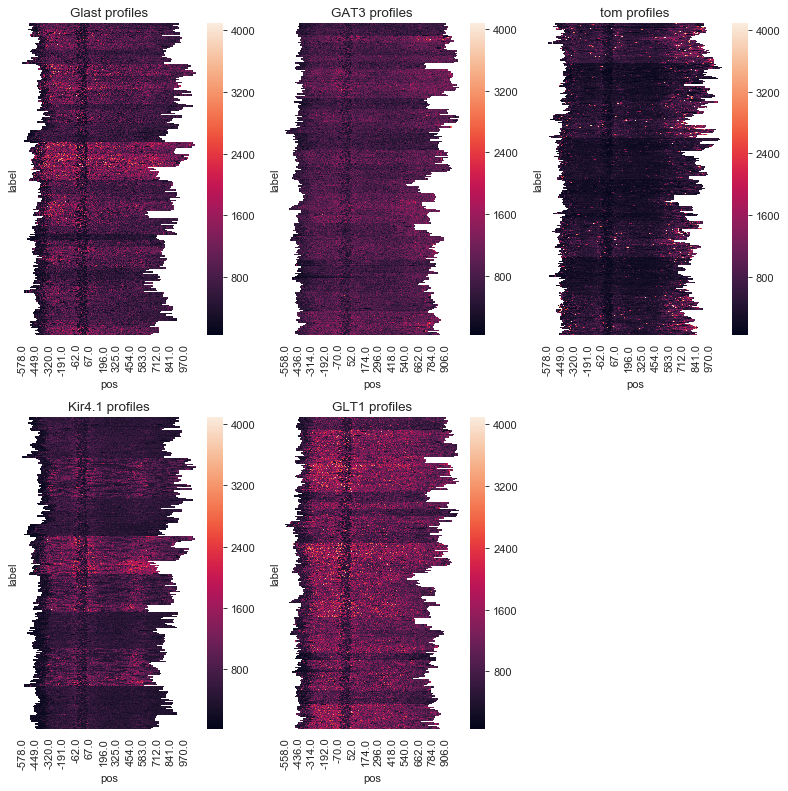

In [49]:
# import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

from profiles import profiles


for i, stain in enumerate(M2.meta['stain'].unique(), start=1):
    ax = fig.add_subplot(2,3, i)
    ax = profiles.plot_heatmap(M2.data, stain)
    i=i+1
fig.tight_layout()

## Plot line per animal

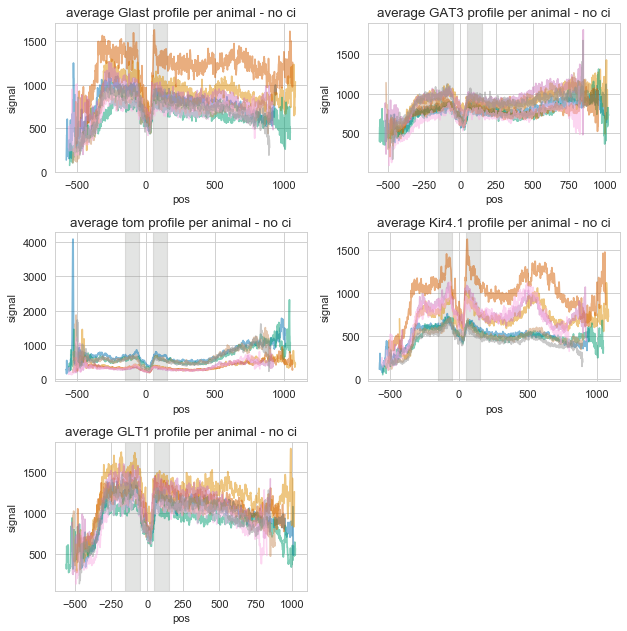

In [50]:
fig = plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')

for i, stain in enumerate(M2.meta['stain'].unique(), start=1):
    ax = fig.add_subplot(3,2, i)
    ax = profiles.trace_per_animal(M2.data, stain)
    ax.get_legend().remove()
fig.tight_layout()
plt.show()

## Plot line per geno - collapsed at animal level
## n = number of animals per geno

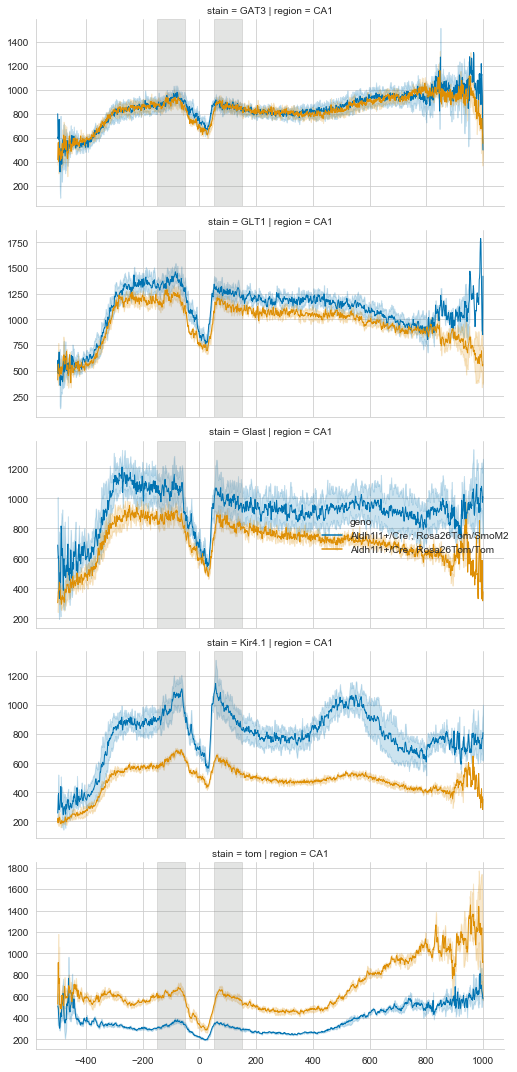

In [51]:
fig = trace_per_animal_by_geno(M2.data)

In [52]:
fig.savefig("../figures/M2_2021_geno_trace.pdf")

## Bar plots of mean signal per region
## n = number of animals per geon

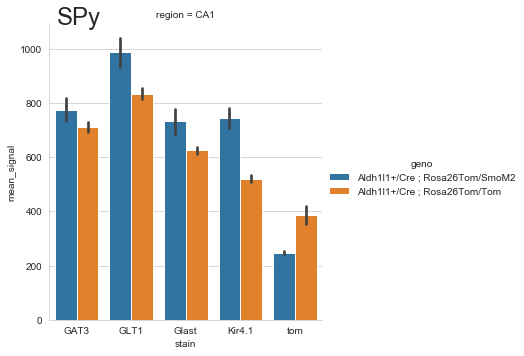

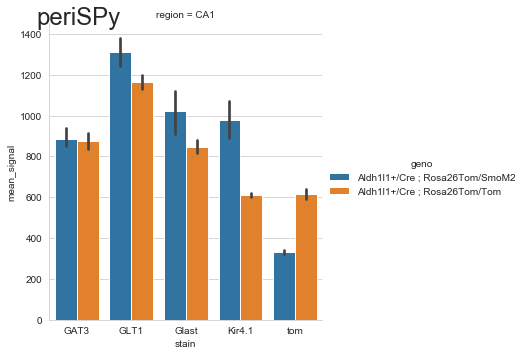

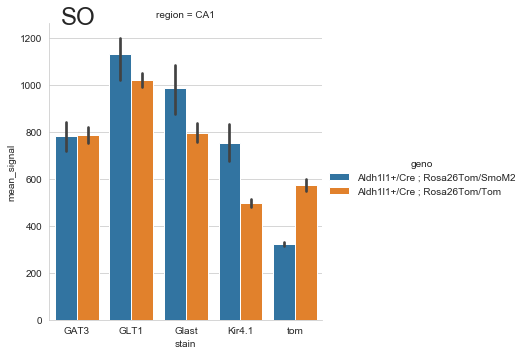

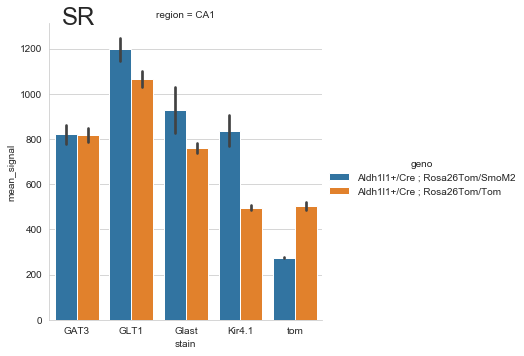

In [53]:
plot_datapoints(M2.data, subregions, style = "bar", save_prefix = "../figures/M2_2021_bar_.pdf")

## T-tests comparing genos in each region, subregion for each stain

In [54]:
t_tests = grouped_ttests(M2.data, subregions)

In [57]:
t_tests

,stain,region,subregion,geno1,geno2,geno1_mean,geno1_sem,geno2_mean,geno2_sem,geno1_n,geno2_n,p-value
0,GAT3,CA1,SPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,776.082652,46.925759,713.574586,18.567862,4,4,0.261743
1,GLT1,CA1,SPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,987.462654,58.708755,835.093410,21.023916,4,4,0.050239
2,Glast,CA1,SPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,732.658849,55.953125,626.177964,13.515913,4,4,0.113816
3,Kir4.1,CA1,SPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,746.544721,38.367513,520.229715,13.215438,4,4,0.001410
4,tom,CA1,SPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,247.745356,6.092943,387.383636,33.296178,4,4,0.006179
5,GAT3,CA1,periSPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,887.231147,48.879440,876.224626,38.977920,4,4,0.866043
6,GLT1,CA1,periSPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,1313.087405,76.498899,1164.504443,41.034721,4,4,0.137816
7,Glast,CA1,periSPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,1023.203290,118.619573,847.567207,30.436410,4,4,0.201508
8,Kir4.1,CA1,periSPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,980.633427,89.351949,610.913805,13.339531,4,4,0.006412
9,tom,CA1,periSPy,Aldh1l1+/Cre ; Rosa26Tom/SmoM2,Aldh1l1+/Cre ; Rosa26Tom/Tom,333.344104,10.239316,615.646295,26.322083,4,4,0.000058


In [55]:
t_tests.to_csv("M2_2021_t_tests.csv")

In [56]:
# save data and meta to disk so it can be plotted with R to match other plots